## Setup

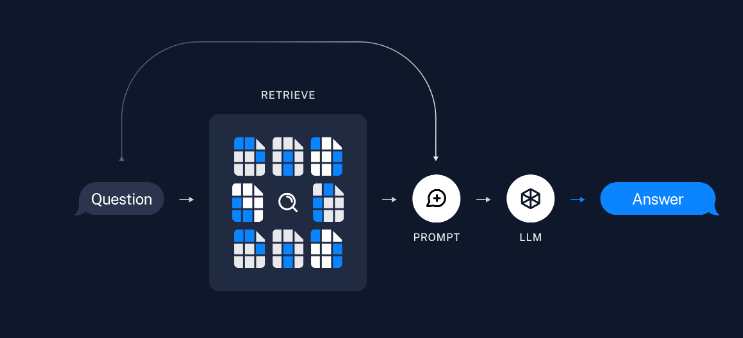

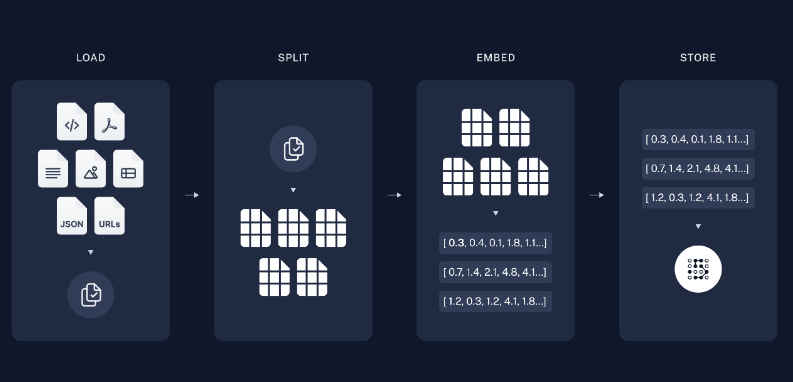

In [73]:
!pip install --quiet langchain langchain-community langchainhub langchain-openai langchain-chroma bs4 datasets evaluate

In [72]:
from google.colab import userdata

## Load text data
1. crawl webpage content
<font color="red"> explain chunk overlap here </font>

In [74]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
# https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html
# default parser: bs4, parse webcontent (basically remove html tags)
loader = WebBaseLoader(web_path="https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html",
                       bs_kwargs = dict(parse_only=bs4.SoupStrainer(
                          class_=("py method")
                       )))
# TODO: explain what is "document" here,
# ref: https://api.python.langchain.com/en/latest/documents/langchain_core.documents.base.Document.html#langchain_core.documents.base.Document
docs = loader.load()

In [75]:
print(len(docs))

1


In [77]:
print(vars(docs[0]).keys())

dict_keys(['page_content', 'metadata', 'type'])


In [80]:
print(docs[0].metadata)

{'source': 'https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html'}


In [84]:
docs[0].page_content

"\n\n__init__(web_path: Union[str, Sequence[str]] = '', header_template: Optional[dict] = None, verify_ssl: bool = True, proxies: Optional[dict] = None, continue_on_failure: bool = False, autoset_encoding: bool = True, encoding: Optional[str] = None, web_paths: Sequence[str] = (), requests_per_second: int = 2, default_parser: str = 'html.parser', requests_kwargs: Optional[Dict[str, Any]] = None, raise_for_status: bool = False, bs_get_text_kwargs: Optional[Dict[str, Any]] = None, bs_kwargs: Optional[Dict[str, Any]] = None, session: Optional[Any] = None) → None[source]Â¶\nInitialize loader.\n\nParameters\n\nweb_paths (Sequence[str]) â€“ Web paths to load from.\nrequests_per_second (int) â€“ Max number of concurrent requests to make.\ndefault_parser (str) â€“ Default parser to use for BeautifulSoup.\nrequests_kwargs (Optional[Dict[str, Any]]) â€“ kwargs for requests\nraise_for_status (bool) â€“ Raise an exception if http status code denotes an error.\nbs_get_text_kwargs (Optional[Dict[str

In [82]:
print(len(docs[0].page_content))

2835


In [86]:
# split long text
# all of the text splitter are listed here: https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/
from langchain_text_splitters import RecursiveCharacterTextSplitter

#You can calculate the average string length as your chunk size
#Chunk_overlap would be better with half of average string length
#predefine text splitter will use '' or '\n\n' or '\n' as the keyword break point
# in this document, we find many \n\n\n and \n\n\n\n\n, you can set these as keywords
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=512,
    add_start_index=True, # TODO: explain parameter, ref: https://api.python.langchain.com/en/latest/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html
    separators=["\n\n\n", "\n\n\n\n"]
)
split_docs = text_splitter.split_documents(docs)
print(len(split_docs))

4


In [97]:
split_docs[0].page_content

"\n\n__init__(web_path: Union[str, Sequence[str]] = '', header_template: Optional[dict] = None, verify_ssl: bool = True, proxies: Optional[dict] = None, continue_on_failure: bool = False, autoset_encoding: bool = True, encoding: Optional[str] = None, web_paths: Sequence[str] = (), requests_per_second: int = 2, default_parser: str = 'html.parser', requests_kwargs: Optional[Dict[str, Any]] = None, raise_for_status: bool = False, bs_get_text_kwargs: Optional[Dict[str, Any]] = None, bs_kwargs: Optional[Dict[str, Any]] = None, session: Optional[Any] = None) → None[source]Â¶\nInitialize loader.\n\nParameters\n\nweb_paths (Sequence[str]) â€“ Web paths to load from.\nrequests_per_second (int) â€“ Max number of concurrent requests to make.\ndefault_parser (str) â€“ Default parser to use for BeautifulSoup.\nrequests_kwargs (Optional[Dict[str, Any]]) â€“ kwargs for requests\nraise_for_status (bool) â€“ Raise an exception if http status code denotes an error.\nbs_get_text_kwargs (Optional[Dict[str

2. load HuggingFace dataset to create a chromdb

In [98]:
import datasets
from datasets import load_dataset

dataset = load_dataset("MediaTek-Research/TCEval-v2", 'drcd')
clean_test = dataset['test'].to_pandas()
clean_test = clean_test[clean_test['references'].apply(len)==1]
clean_test['references'] = clean_test['references'].apply(lambda x: x[0])
clean_test = clean_test.rename(columns={"paragraph":"context", "references":"answer"})
clean_test = clean_test.sample(frac=1).reset_index(drop=True)
clean_test = clean_test[:100].copy(deep=True).reset_index(drop=True)
len(clean_test)

<ipython-input-98-12bad74a6406>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_test['references'] = clean_test['references'].apply(lambda x: x[0])


100

In [104]:
clean_test.head()

,id,context,question,answer
0,test-1423,早期的時候，越南人並沒有為自己的語言發明適合的書寫系統。大約從東漢開始，漢字開始有系統和大規...,現在的越南語使用拉丁字母書寫，叫做國語字，是由誰整理發展的?,法國傳教士亞歷山大·羅德
1,test-1321,民國三十六年11月21日至23日依憲法規定舉行第一屆中華民國國民大會代表選舉，民國三十七年1...,第一屆中華民國總統是誰?,蔣中正
2,test-2427,洪武三十一年，朝鮮發生「戊寅靖社」，李成桂決定立即引退並將王位讓給二子李芳果，就是朝鮮定宗。...,李成桂在什麼時候決定讓王位給李芳果?,洪武三十一年
3,test-1340,物理光學，或稱波動光學，建立在惠金斯原理之上，可以建立復波前通過光學系統的模型。這一技術能夠...,物理光學表示它比幾何光學更接近物理原理，但不能像哪個的模型模型那樣能夠全面描述光傳播?,電磁波理論模型
4,test-2082,高加索山脈，呈東西走向，在黑海與裏海之間，是俄羅斯和喬治亞、亞塞拜然等國的國界線。其最高峰為...,高加索山脈內的最高峰高達海拔多少米?,5642米


In [100]:
# build documents as from raw text
docs, corpus = [], []
from langchain.docstore.document import Document
for _, record in clean_test.iterrows():
    corpus.append(record['context'])
    docs.append(Document(page_content=record['context'], metadata={"id": record['id']}))

In [102]:
corpus[0]

'早期的時候，越南人並沒有為自己的語言發明適合的書寫系統。大約從東漢開始，漢字開始有系統和大規模的傳入越南。到了越南陳朝以後，漢字已經成為越南政府以及民間的主要文字，此時大量的漢字著作開始出現，最著名的就是15世紀編撰的《大越史記全書》。值得注意是，這些以漢字寫成的文章基本上並不按照越南語的文法規則書寫，也不採用越南語的辭彙，而是純粹的用古漢語的文法寫成。故此，這些漢字著作是漢文著作，而與當時的越南語口語有很大差異。由於越南口語與漢語不同，文言文無法準確紀錄越南本民族語言，在漢字在越南逐漸傳播開後，一些人開始嘗試以漢字作為基礎，以創造新的文字來紀錄越南本民族語言，這些字就是喃字。大約在8世紀的時候喃字開始出現，13世紀的時候，越南文人開始用喃字進行文學創作。此間最著名的文學作品莫過於阮攸19世紀寫成的《金雲翹傳》。越南上層社會由於有很濃厚的尊漢思想，一直很排斥這種文字，國家教育機關也沒有將它作為正式文字看待，也沒有對它進行整理規範的工作。儘管此間的胡朝或者是西山阮朝富春朝廷政權之統治者曾經重視喃字，並且將其提升到國家文書用字的地位。現在的越南語使用拉丁字母書寫，叫做國語字。它是由17世紀到越南的法國傳教士亞歷山大·羅德，根據先前傳教士的拼寫原則的基礎上整合而成。在19世紀法國佔領越南時期，這種書寫體系流行起來，並於20世紀全面開始使用。'

In [103]:
docs[0]

Document(page_content='早期的時候，越南人並沒有為自己的語言發明適合的書寫系統。大約從東漢開始，漢字開始有系統和大規模的傳入越南。到了越南陳朝以後，漢字已經成為越南政府以及民間的主要文字，此時大量的漢字著作開始出現，最著名的就是15世紀編撰的《大越史記全書》。值得注意是，這些以漢字寫成的文章基本上並不按照越南語的文法規則書寫，也不採用越南語的辭彙，而是純粹的用古漢語的文法寫成。故此，這些漢字著作是漢文著作，而與當時的越南語口語有很大差異。由於越南口語與漢語不同，文言文無法準確紀錄越南本民族語言，在漢字在越南逐漸傳播開後，一些人開始嘗試以漢字作為基礎，以創造新的文字來紀錄越南本民族語言，這些字就是喃字。大約在8世紀的時候喃字開始出現，13世紀的時候，越南文人開始用喃字進行文學創作。此間最著名的文學作品莫過於阮攸19世紀寫成的《金雲翹傳》。越南上層社會由於有很濃厚的尊漢思想，一直很排斥這種文字，國家教育機關也沒有將它作為正式文字看待，也沒有對它進行整理規範的工作。儘管此間的胡朝或者是西山阮朝富春朝廷政權之統治者曾經重視喃字，並且將其提升到國家文書用字的地位。現在的越南語使用拉丁字母書寫，叫做國語字。它是由17世紀到越南的法國傳教士亞歷山大·羅德，根據先前傳教士的拼寫原則的基礎上整合而成。在19世紀法國佔領越南時期，這種書寫體系流行起來，並於20世紀全面開始使用。', metadata={'id': 'test-1423'})

## Load public embedding model from huggineface






In [105]:
!pip install -q langchain-huggingface

1. HuggingFace embedding model [API document](dochttps://api.python.langchain.com/en/latest/embeddings/langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings.html)

In [108]:
# This packs HF-model as a function
# TODO: explain embeddin gmodel, ref: https://api.python.langchain.com/en/latest/embeddings/langchain_core.embeddings.embeddings.Embeddings.html#langchain_core.embeddings.embeddings.Embeddings
from langchain_huggingface import HuggingFaceEmbeddings
mini_embed_func = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [109]:
embedded_sentence = mini_embed_func.embed_query("This is a test sentence.")
print(len(embedded_sentence))

384


In [110]:
embedded_documents = mini_embed_func.embed_documents(["This is a test sentence.", "This is another test sentence."])
print(len(embedded_documents))
print(len(embedded_documents[0]))

2
384


2. OpenAI embedding

In [111]:
from langchain_openai import AzureOpenAIEmbeddings


embed_func = AzureOpenAIEmbeddings(deployment="text-embedding-3-large",
                               openai_api_key=userdata.get('mtk-open-key'),
                               azure_endpoint='https://mtknycuragwebinar.openai.azure.com/',
                               openai_api_version='2024-05-01-preview',
                               max_retries=10,
                               chunk_size=128,
                               show_progress_bar=True)

In [ ]:
embedded_sentence = embed_func.embed_query("This is a test sentence.")
print(len(embedded_sentence))

  0%|          | 0/1 [00:00<?, ?it/s]

3072


## Vector store
- create database

In [113]:
# store vectors to chroma db
# chroma API doc: https://python.langchain.com/v0.1/docs/integrations/vectorstores/chroma/
from langchain_chroma import Chroma
Chroma().delete_collection()
vectorstore = Chroma.from_documents(documents=docs, embedding=embed_func)
print(len(vectorstore.get()['documents']))

  0%|          | 0/1 [00:00<?, ?it/s]

100


- query database

In [117]:
# approach 1: directly use vectorstore to query
q="NBA張伯倫每場比賽有幾個籃板?"
vectorstore.similarity_search_with_score(q, k=5)

  0%|          | 0/1 [00:00<?, ?it/s]

[(Document(page_content='1968年7月9日，洛杉磯湖人以達雷爾·英霍夫，阿奇·克拉克和傑里·錢伯斯從費城76人隊換來威爾特·張伯倫。張伯倫在第一個賽季創造球隊紀錄場，每場比賽21.1個籃板。傑瑞·威斯特，艾爾金·貝勒，張伯倫平均每場比賽可得20分，洛杉磯贏得分區首位。湖人和波士頓塞爾提克隊於總決賽再次相遇，洛杉磯有主場優勢。第一場比賽傑瑞·威斯特獲得53分，洛杉磯湖人獲勝，並曾以3-2領先。波士頓塞爾提克隊在第七場比賽獲勝，贏得他們第11次NBA總冠軍。傑里·威斯特特為有史以來第一個落敗球隊獲得總決賽MVP。在1970年，傑里·威斯特特贏得第一個得分王頭銜，洛杉磯湖人回到總決賽，他們沒面對波士頓塞爾提克，而是紐約尼克。下個賽季，洛杉磯湖人在西區分區系列被密爾瓦基公鹿隊擊敗。1971-72賽季，洛杉磯湖人有一些變化。老闆傑克·肯特庫克聘僱比爾·夏曼為總教練，艾爾金·貝勒意識到他的腿不夠健康後，在本賽季初宣布退休。夏曼增加球隊的紀律，提升投籃訓練。洛杉磯湖人贏得33連勝，也是美國職業體育的紀錄保持人。那個賽季，湖人贏69場比賽，紀錄保持24年之久，直到芝加哥公牛隊贏得72場比賽之後。張伯倫場均14.8分，但是籃板19.2個。傑瑞·威斯特每場比賽9.7次助攻領先全聯盟，場均超過25分，被評為1972年NBA全明星賽最有價值球員。洛杉磯湖人全年只有一次未能得分超過100分，在賽季結束後，比爾·夏曼被評為年度最佳教練。洛杉磯湖人決賽對紐約尼克，並以4-1擊敗該隊。張伯倫贏得NBA總決賽最有價值球員獎。1972－1973年賽季，湖人隊贏得60場比賽，取得太平洋區冠軍。張伯倫是生涯最後一個賽季，再次獲得籃板王，投籃命中率為72.7％。洛杉磯湖人在半決賽第七場擊敗了芝加哥公牛隊。洛杉磯湖人於1973年NBA總決賽以1-4不敵紐約尼克。', metadata={'id': 'test-934'}),
  1.0413579940795898),
 (Document(page_content='2002年世界盃，羅納度、羅納爾迪尼奧、卡路士、卡福與里瓦爾多成為巴西核心球員。巴西是少數沒有表現失準的傳統強隊，先在十六強賽以2-0淘汰比利時，八強賽以2比1淘汰英格蘭，準決賽1比0擊敗土耳其晉身決賽，決賽巴西以2-0擊敗德國，這時巴西已創下五奪世界盃紀錄，乃史無前

In [119]:
from tqdm.notebook import tqdm
results = []
# vectorstore.embeddings.show_progress_bar=False
for _, record in tqdm(clean_test.iterrows(), total=len(clean_test)):
  q = record['question']
  retrieved_docs = vectorstore.similarity_search_with_score(q, k=5)
  results.append(retrieved_docs)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [123]:
#calculate hit rate with top 5 document and top 1 document
top1, top5 = 0,0
for i, result in enumerate(results):
  record = clean_test.iloc[i]
  gt = record['id']
  top1_pred = result[0][0].metadata['id']
  if top1_pred == gt:
    top1+=1
  for (doc, score) in result:
    pred = doc.metadata['id']
    if pred == gt:
      top5+=1
print(len(clean_test))
print("top 5 hit rate:",top5/len(clean_test))
print("top 5 hit rate:",top1/len(clean_test))

100
top 5 hit rate: 0.94
top 5 hit rate: 0.84


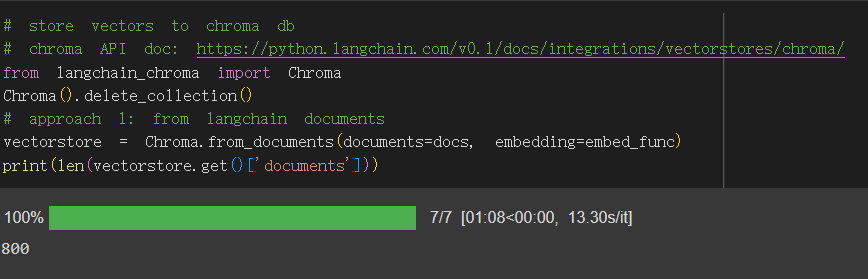

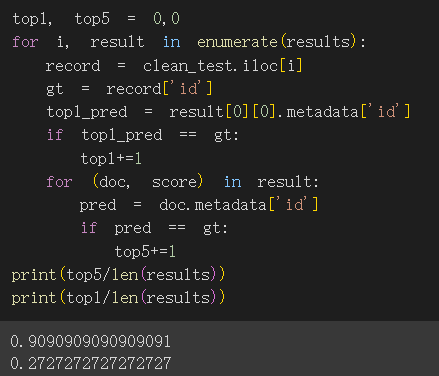

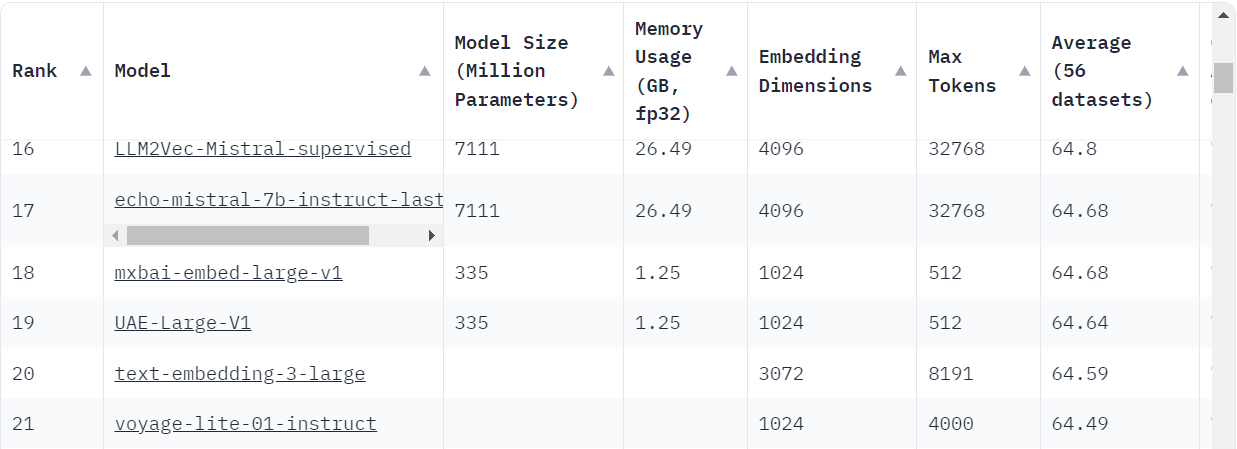

## Build LLM API service

In [ ]:
from langchain_openai import AzureChatOpenAI
# chat openai https://api.python.langchain.com/en/latest/chat_models/langchain_openai.chat_models.azure.AzureChatOpenAI.html
llm = AzureChatOpenAI(
    openai_api_version='2024-05-01-preview',
    azure_deployment='gpt-4o',
    azure_endpoint='https://mtknycuragwebinar.openai.azure.com',
    openai_api_key=userdata.get('mtk-open-key'),
)

## RAG: integrating LLM to generate

*   prepare your prompt
*   system message can affect your LLM generation style
*   HumanMessage affect your generation content
*   RAG can give model a "book" and tell model use the book to answer your question





In [133]:
from langchain_core.messages import SystemMessage
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
# The basic unit of a conversation is message
# A message comes with "role" and "content"
# generally, there are only three roles in conversation: "system", "Human", "AI"
sys_message = SystemMessage(
    content=(
        "你是一個海盜，你會用有趣的腔調回答問題"
))
# you can format message with your variable
human_message = HumanMessagePromptTemplate.from_template("問題：{question}")
human_message = human_message.format(question='2024NB總冠軍是哪一對?')
# finally create chat with messages
full_prompt = [sys_message, human_message]
print(full_prompt)

[SystemMessage(content='你是一個海盜，你會用有趣的腔調回答問題'), HumanMessage(content='問題：2024NB總冠軍是哪一對?')]


In [134]:
llm.invoke(full_prompt).content

'啊哈，船長我可沒那水晶球來預見未來啊！不過若要猜想2024年NBA總冠軍是哪一隊，那得看各隊的表現和命運之風如何吹拂！是勇士隊的海鷹再度展翅，還是湖人隊的巨艦再度揚帆？亦或是某支黑馬隊伍突如其來？咱們只有等到那時，和手中的朗姆酒一起見證啦！嗚哈哈哈！'

In [139]:
sys_message = SystemMessage(
    content=(
        "你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答"
))
human_message = HumanMessagePromptTemplate.from_template("問題：{question}")
human_message = human_message.format(question='2024NB總冠軍是哪一對?')
# finally create chat with messages
full_prompt = [sys_message, human_message]
print(full_prompt)

[SystemMessage(content='你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答'), HumanMessage(content='問題：2024NB總冠軍是哪一對?')]


In [140]:
llm.invoke(full_prompt).content

'對不起，根據目前的資料，我無法提供2024年NBA總冠軍的信息。'

In [135]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=cdfd3fb02bd1fc96d4ab46e05f8b4f7e8401b2994a66069c726ff80f141cd5d9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import evaluate

rouge = evaluate.load('rouge') ## import the rouge scorer

for r, record in clean_test.iterrows():
  q = record['question']
  retrieved_docs = vectorstore.similarity_search_with_score(q, k=5)
  gt = record['answer']
  gt_doc_messages = chat_template.format_messages(question=q, context=record['context'])
  response1 = llm.invoke(gt_doc_messages)
  ret_doc_messages = chat_template.format_messages(question=q, context=retrieved_docs[0][0].page_content)
  response2 = llm.invoke(ret_doc_messages)
  print(gt)
  print(response1)
  print(response2)
  break

梵語
content='梵語。' response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 460, 'total_tokens': 464}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}} id='run-19a8d622-427f-41be-af6c-8e4146dbc118-0' usage_metadata={'input_tokens': 460, 'output_tokens': 4, 'total_tokens': 464}
content='梵語' response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 346, 'total_tokens': 349}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}} id='run-f92948c8-ded5-46cd-9274-6e106c6529a1-0' usage_metadata={'input_tokens': 346, 'output_tokens': 3, 'total_tokens': 349}


In [ ]:
rouge.compute(predictions=[response1.content],
              references=[gt],
              tokenizer=lambda x: [c for c in x]
)

{'rouge1': 0.8, 'rouge2': 0.6666666666666666, 'rougeL': 0.8, 'rougeLsum': 0.8}

## <font color="blue"> TODO 1 </font>
Question: 塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?

In [ ]:
# TODO 1
# step1: crawl web content from webpage
# step2: spilt your web content
# step3: create vector store with embedding model and insert into chromdb
# step4: write your rag prompt
# step5: ask LLM question with given document

In [148]:
loader = WebBaseLoader(web_path="https://www.nytimes.com/athletic/5571475/2024/06/17/celtics-mavericks-nba-finals-game-5-score-result/")
docs = loader.load()

In [149]:
split_docs = text_splitter.split_documents(docs)
print(len(split_docs))

2


In [150]:
vectorstore = Chroma.from_documents(documents=split_docs, embedding=embed_func)
print(len(vectorstore.get()['documents']))

  0%|          | 0/1 [00:00<?, ?it/s]

102


In [151]:
sys_message = SystemMessage(
    content=(
        "你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答"
))
human_message = HumanMessagePromptTemplate.from_template("問題：{question}")
human_message = human_message.format(question='基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?')
# finally create chat with messages
full_prompt = [sys_message, human_message]
print(full_prompt)

[SystemMessage(content='你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答'), HumanMessage(content='問題：基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?')]


In [152]:
llm.invoke(full_prompt).content

'我不知道。'

In [154]:
q="基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?"
document=vectorstore.similarity_search_with_score(q, k=5)

  0%|          | 0/1 [00:00<?, ?it/s]

In [155]:
sys_message = SystemMessage(
    content=(
        "你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答"
))
human_message = HumanMessagePromptTemplate.from_template("問題：{question}")
human_message = human_message.format(question='基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?'+str(document))
# finally create chat with messages
RAG_prompt = [sys_message, human_message]
print(RAG_prompt)

[SystemMessage(content='你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答'), HumanMessage(content='問題：基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?[(Document(page_content="Celtics capture 18th NBA championship with Game 5 win over Mavericks - The AthleticNBATeamsScores & ScheduleNBA DraftPlayoff BracketThe Bounce NewsletterPodcastsStandingsFantasyNBA OddsNBA PicksCeltics make historyNBA free agency loomsCeltics capture 18th NBA championship with Game 5 win over Mavericks By Joe VardonJun 18, 2024BOSTON ‚Äî The Boston Celtics are again champions of the NBA, having claimed a milestone title Monday night that will reverberate from coast to coast and carve out legacies for the current pillars of this storied franchise.The Celtics beat the Dallas Mavericks 106-88 in Game 5 of the 2024 NBA Finals to win the series 4-1 and claim a league-record 18th NBA championship.AdvertisementA sea of green and white confetti fell from the rafters at TD Garden before Celtics coach Joe Mazzulla, the younges

In [156]:
llm.invoke(RAG_prompt).content

'106-88'

# Congratulation !
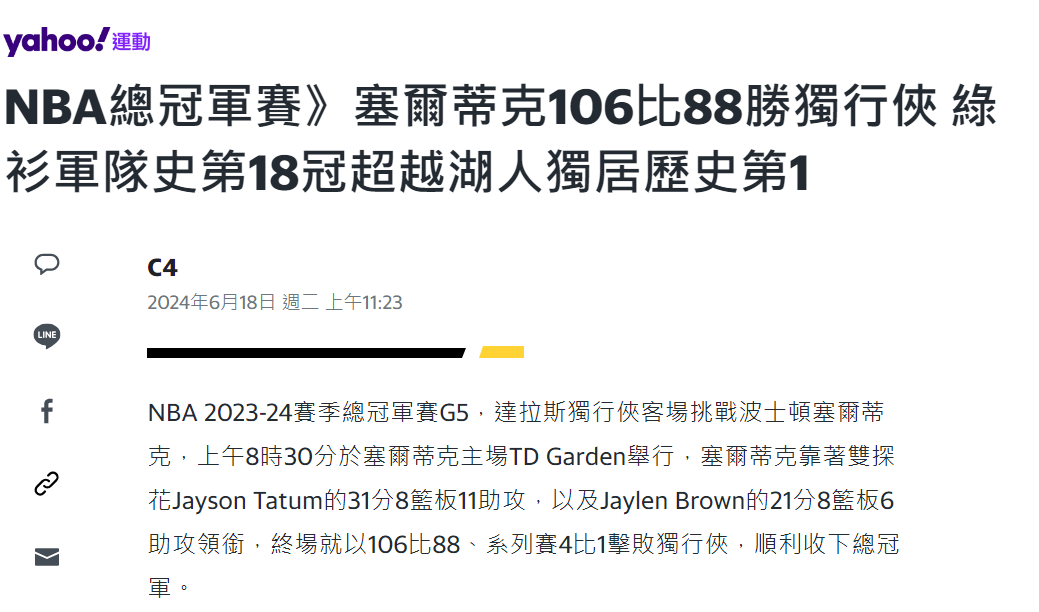